# Universal Approximation Theorem
A feedforward network with `1 hidden layer` and a `sufficient number of neurons` can approximate any continuous function on a compact domain.

# What if no hidden layer
Without a hidden layer, the network is just a linear model.

# Which activation function
- To approximate non-linear functions, the activation in the hidden layer must be non-linear (like ReLU, sigmoid, tanh, etc.).
- Without non-linearity, the network behaves like a linear transformation, no matter how many layers you stack.

# Introduction
- This notebook will create a 3 classes: UNN, RegressionUNN, ClassificationUNN
- The class UNN have 3 following layers:
  + 1 input layer
  + 1 hidden layer -> ReLU activation function
  + 1 output layer -> Linear activation function, Softmax activation function
- The class RegressionUNN:
  + Activation function for output layer: Linear activation function
  + Loss function: Mean Squared Error (MSE) or  Mean Absolute Error (MAE)
- The class ClassificationUNN:
  + Activation function for output layer: Softmax activation function
  + Loss function: Categorical Cross-Entropy Loss

In [3]:
import numpy as np
from numpy.typing import NDArray
from typing import Literal

af64 = NDArray[np.float64]

class UNN:
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        seed: int = 42,
    ):
        np.random.seed(seed)
        self.w1: af64 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1: af64 = np.zeros((1, hidden_size))
        self.w2: af64 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2: af64 = np.zeros((1, output_size))

    def relu(self, x: af64) -> af64:
        return np.maximum(0, x)

    def relu_derivative(self, x: af64) -> af64:
        return (x > 0).astype(float)

    def forward_hidden(self, X: af64):
        self.Z1 = X @ self.w1 + self.b1
        self.A1 = self.relu(self.Z1)

    def backward_hidden(
        self,
        dA1: af64,
        X: af64,
    ) -> tuple[af64, af64, af64]:
        dZ1: af64 = dA1 * self.relu_derivative(self.Z1)
        dW1: af64 = X.T @ dZ1
        db1: af64 = np.sum(dZ1, axis=0, keepdims=True)
        return dZ1 @ self.w1.T, dW1, db1

    def update(
        self,
        grads: tuple[af64, af64, af64, af64],
        lr: float,
    ):
        dW1, db1, dW2, db2 = grads
        self.w1 -= lr * dW1
        self.b1 -= lr * db1
        self.w2 -= lr * dW2
        self.b2 -= lr * db2

class RegressionUNN(UNN):
    def forward(self, X: af64) -> af64:
        self.forward_hidden(X)
        self.Z2 = self.A1 @ self.w2 + self.b2
        return self.Z2  # Linear output

    def compute_loss(
            self,
            y_pred: af64,
            y_true: af64,
            loss: Literal["mse", "mae"] ="mse",
        ) -> np.float64:
        if loss == "mse":
            return np.mean((y_pred - y_true) ** 2)
        elif loss == "mae":
            return np.mean(np.abs(y_pred - y_true))

    def backward(
            self,
            X: af64,
            y_true: af64,
            y_pred: af64,
            loss: Literal["mse", "mae"] ="mse",
        ) -> tuple[af64, af64, af64, af64]:
        if loss == "mse":
            dZ2 = 2 * (y_pred - y_true) / y_true.shape[0]
        elif loss == "mae":
            dZ2 = np.sign(y_pred - y_true) / y_true.shape[0]

        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.w2.T
        _, dW1, db1 = self.backward_hidden(dA1, X) # _ is dX

        return dW1, db1, dW2, db2

class ClassificationUNN(UNN):
    def softmax(self, x: af64) -> af64:
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, X: af64) -> af64:
        self.forward_hidden(X)
        self.Z2 = self.A1 @ self.w2 + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(
        self,
        y_pred: af64,
        y_true: af64,
    ) -> np.float64:
        # y_true is one-hot encoded
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def backward(
        self,
        X: af64,
        y_true: af64,
        y_pred: af64,
    ) -> tuple[af64, af64, af64, af64]:
        dZ2 = (y_pred - y_true) / y_true.shape[0]
        dW2 = self.A1.T @ dZ2
        db2: af64 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.w2.T
        _, dW1, db1 = self.backward_hidden(dA1, X) # _ is dX

        return dW1, db1, dW2, db2

---

Example using RegressionUNN

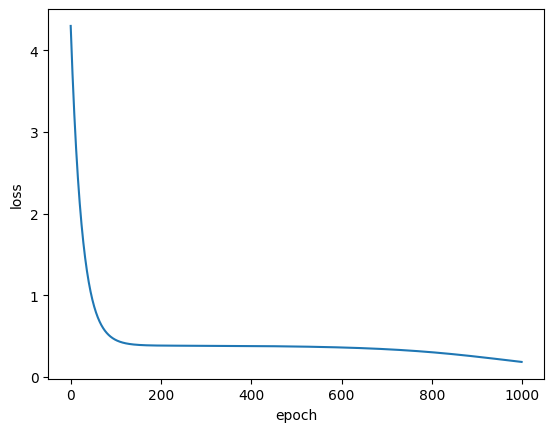

In [ ]:
import matplotlib.pyplot as plt

def test():
    # Sample regression data: 100 samples, 1 feature
    X_train: af64 = np.random.rand(100, 1)  # Input (100 samples, 1 feature)
    y_train: af64 = 2 * X_train + 1 + np.random.randn(100, 1) * 0.1  # Output (Linear relationship with noise)

    # Initialize model
    model = RegressionUNN(input_size=1, hidden_size=10, output_size=1)

    # Training loop
    epochs: int = 1000
    learning_rate: float = 0.01
    losses: list[np.float64] = []
    for _ in range(epochs):
        # Forward pass
        y_pred: af64 = model.forward(X_train)
        
        # Compute loss
        loss: np.float64 = model.compute_loss(y_pred, y_train, loss="mse")
        
        # Backward pass
        grads = model.backward(X_train, y_train, y_pred, loss="mse")
        
        # Update weights
        model.update(grads, lr=learning_rate)
        
        losses.append(loss)
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(losses)
    plt.show()

test()

---

Example using ClassificationUNN

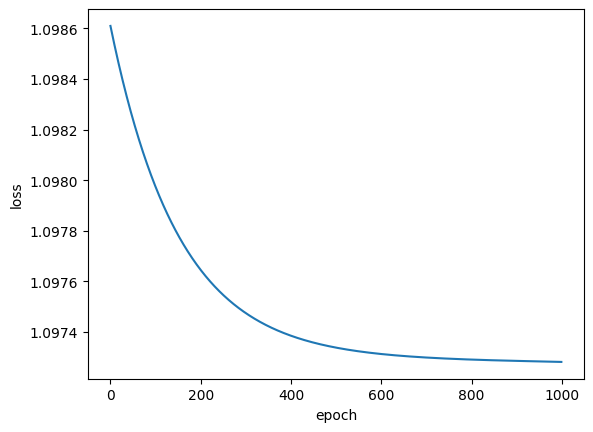

In [ ]:
import matplotlib.pyplot as plt

def test():
    # Sample classification data: 100 samples, 3 classes
    X_train: af64 = np.random.rand(100, 5)  # Input (100 samples, 5 features)
    y_train: af64 = np.zeros((100, 3))  # One-hot encoded output (100 samples, 3 classes)
    for i in range(100):
        y_train[i, np.random.choice(3)] = 1  # Randomly assign a class to each sample

    # Initialize model
    model = ClassificationUNN(input_size=5, hidden_size=10, output_size=3)

    # Training loop
    epochs: int = 1000
    learning_rate: float = 0.01
    losses: list[np.float64] = []
    for _ in range(epochs):
        # Forward pass
        y_pred: af64 = model.forward(X_train)
        
        # Compute loss
        loss = model.compute_loss(y_pred, y_train)
        
        # Backward pass
        grads = model.backward(X_train, y_train, y_pred)
        
        # Update weights
        model.update(grads, lr=learning_rate)
        
        losses.append(loss)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(losses)
    plt.show()

test()